In [1]:
'Expt alpha-2'
%load_ext autoreload
%autoreload 2
from snippets.loader import *
# from data.MNIST.load_mnist import *

device = 'cpu' if torch.cuda.is_available() else 'cpu'

trndata = loaddill('mnist.train.16.data')
valdata = loaddill('mnist.val.16.data')[:256] 
size = trndata[0][0].shape
id_cat = {str(i):i for i in range(10)}

channel_mapping = {v+1:k for k,v in id_cat.items()}
channel_mapping[0] = 'background'

id_mapping = {v:k for k,v in channel_mapping.items()}
logger.info(f'Channel to Object: {channel_mapping}')
logger.info(f'Object to Channel: {id_mapping}')

print(f'Train: {len(trndata)}\tVal: {len(valdata)}\nSize {size}\n{len(id_cat)} Classes')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
logger.info(f'Using device:`{device}`'.upper())

ix = randint(len(trndata))
a,b,c = trndata[ix]
show(a, texts=c, bbs=b, th=1, sz=5); plt.show()

2020-03-14 15:55:11.165 | INFO     | __main__:<module>:18 - Channel to Object: {1: '0', 2: '1', 3: '2', 4: '3', 5: '4', 6: '5', 7: '6', 8: '7', 9: '8', 10: '9', 0: 'background'}
2020-03-14 15:55:11.166 | INFO     | __main__:<module>:19 - Object to Channel: {'0': 1, '1': 2, '2': 3, '3': 4, '4': 5, '5': 6, '6': 7, '7': 8, '8': 9, '9': 10, 'background': 0}
2020-03-14 15:55:11.166 | INFO     | __main__:<module>:24 - USING DEVICE:`CUDA`


Train: 2000	Val: 200
Size (100, 100)
10 Classes


<Figure size 500x500 with 1 Axes>

In [2]:
class ImageObjects(Dataset):
    def __init__(self, data):
        self.data = data
        
    def __len__(self)    : return len(self.data)
    def __getitem__(self, ix):
        im, bbs, clss = self.data[ix]
        # construct heatmaps from bbs and clss
        # show(im, bbs=bbs, texts=clss, th=1, sz=5)
        return im, bbs, [str(c) for c in clss]
        
trn = ImageObjects(trndata)
im, bbs, clss = trn[randint(len(trn))]

In [3]:
def IOU(b1, b2):
    x,y,X,Y = b1
    a,b,A,B = b2
    assert x<=X and y<=Y and a<=A and b<=B
    A_b1 = (X-x)*(Y-y)
    A_b2 = (A-a)*(B-b)
    xa, ya = max(x,a), max(y,b)
    xb, yb = min(X,A), min(Y,B)
    intersection = max(0,(xb-xa)) * max(0,(yb-ya))
    union = A_b1 + A_b2 - intersection
    return intersection / union

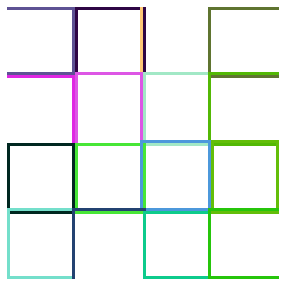

In [6]:
Blank = lambda shape: (255*np.ones(shape)).astype(np.uint8)
def show_anchor_boxes(heatmap_info, jitter=1):
    R,C,W,H,sub_crop_scale,sub_h,sub_w,stride_h,stride_w = heatmap_info
    bbs = []
    for r in range(R):
        for c in range(C):
            bbs.append(BB(c*stride_w, r*stride_h, c*stride_w+sub_w, r*stride_h+sub_h))
    show(Blank((H,W)), bbs=[bb.jitter(jitter) for bb in bbs], bb_colors='random', sz=5, th=1)
    
R,C = 4,4
H,W = im.shape
sub_h,sub_w = H/4, W/4
sub_crop_scale = 1.05
stride_h, stride_w = int((H-sub_h)/(R-1)), int((W-sub_w)/(C-1))
heatmap_info = R,C,W,H,sub_crop_scale,sub_h,sub_w,stride_h,stride_w

show_anchor_boxes(heatmap_info)

2020-03-14 15:55:33.528 | INFO     | __main__:HMsToBBsClss:43 - Object: `3` found at Channel# 4
2020-03-14 15:55:33.529 | INFO     | __main__:HMsToBBsClss:44 - Found object at location: (0, 0)
2020-03-14 15:55:33.529 | INFO     | __main__:HMsToBBsClss:45 - Anchor: (0, 0, 25, 25)	Delta: (-1, 0, 3, 1)	Corrected: (1, 0, 21, 23)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Item number: 1632


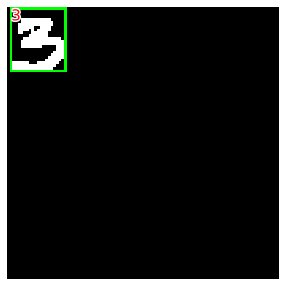

In [7]:
def BBsClssToHMs(bbs, objs, heatmap_info=heatmap_info) -> ['RxCx(1+NCls)','RxCx4*(NCls)']:
    'returns 2 arrays - one for classification task and one for regression task'
    R,C,W,H,sub_crop_scale,sub_h,sub_w,stride_h,stride_w = heatmap_info
    clss_map, regr_map = np.zeros((R,C,1+len(id_cat))).astype(np.float32), np.zeros((R,C,4*(1+len(id_cat)))).astype(np.float32)
    for bb, obj in zip(bbs, objs):
        bb = BB(bb)
        clss = np.zeros((R,C))
        regr = np.zeros((R,C,4))
        for r in range(R):
            for c in range(C):
                anc = anchor_box = BB(c*stride_w, r*stride_h, c*stride_w+sub_w, r*stride_h+sub_h)
                iou = IOU(bb, anc)
                if iou == 0: continue
                clss[r,c] = iou
                dx, dy = anc.x - bb.x, anc.y - bb.y
                dX, dY = anc.X - bb.X, anc.Y - bb.Y
                regr[r,c] = dx/W, dy/H, dX/W, dY/H
        cls_channel_id = id_mapping[obj]
        clss_map[...,cls_channel_id] += clss
        regr_map[...,cls_channel_id*4:(1+cls_channel_id)*4] += regr
    regr_map[...,0] = np.clip(1 - regr_map.sum(-1), 0, 1)
    return clss_map, regr_map
def HMsToBBsClss(clss_map, regr_map, heatmap_info=heatmap_info, threshold=0.1, debug=True):
    assert len(clss_map.shape) == 3, 'Please pass tensor of shape R x C x (1+NCls)'
    assert len(regr_map.shape) == 3, 'Please pass tensor of shape R x C x 4*NCls'
    R,C,W,H,sub_crop_scale,sub_h,sub_w,stride_h,stride_w = heatmap_info
    found_bbs = []
    found_cls = []
    for channel_ix in range(clss_map.shape[-1]):
        if channel_ix == 0: continue
        clss_id = channel_mapping[channel_ix]
        clss = clss_map[...,channel_ix]
        clss = clss > threshold
        rs, cs = np.nonzero(clss)
        regr = regr_map[...,channel_ix*4:(1+channel_ix)*4]
        for r,c in zip(rs, cs):
            anc = anchor_box = BB(c*stride_w, r*stride_h, c*stride_w+sub_w, r*stride_h+sub_h)
            dx,dy,dX,dY = regr[r,c]
            dx,dY,dX,dY = dx*W, dy*H, dX*W, dY*H
            delta = BB(dx,dy,dX,dY)
            corrected_bb = BB(max(0,anc.x-dx), max(0,anc.y-dy), anc.X-dX, anc.Y-dY)
            if debug:
                logger.info(f'Object: `{clss_id}` found at Channel# {channel_ix}')
                logger.info(f'Found object at location: {(r,c)}')
                logger.info('Anchor: {}\tDelta: {}\tCorrected: {}\n'.format(anc, delta, corrected_bb))
            found_bbs.append(corrected_bb)
            found_cls.append(clss_id)
            # show(im, bbs=[anc, corrected_bb], bb_colors=[(0,255,255),(255,0,255)])
    return found_bbs, found_cls
ix = randint(len(trn))
print('Item number:',ix)
im, bbs, clss = trn[ix]
clss, regr = BBsClssToHMs(bbs, clss)
_bbs, _clss = HMsToBBsClss(clss, regr)
show(im, bbs=_bbs, texts=_clss, sz=5, th=1)